In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table

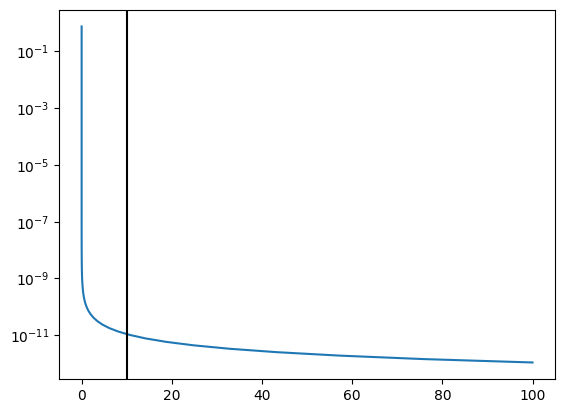

In [57]:
X= logspace(-10,2,100)
Y=22.5-2.5*log10(X)
Y1=22.5-2.5*log10(X+1e-10)
plot(X,Y-Y1)
axvline(10,color='k')
yscale('log')

In [80]:
from dl import queryClient as qc

In [166]:
bricks_edges = 240000 + np.array(range(20))*20000
bricks_edges[-1] = 662174

In [156]:
def rezaie_query_maker(brick_start,brick_end,hemisphere="N"):
    """Makes queries as Rezaie 2023 for the LS LRGs"""
    myquery = f"""SELECT
    	RA,
    	DEC,
    	OBJID,
    	BRICKID ,
    	22.5-LOG(FLUX_G*MW_TRANSMISSION_G)/LOG(10) AS MAG_G,
    	22.5-LOG(FLUX_R*MW_TRANSMISSION_R)/LOG(10) AS MAG_R,
    	22.5-LOG(FLUX_Z*MW_TRANSMISSION_Z)/LOG(10) AS MAG_Z,
    	22.5-LOG(FLUX_W1*MW_TRANSMISSION_W1)/LOG(10) AS MAG_W1
    FROM
    	LS_DR9.TRACTOR_{hemisphere}
    
    WHERE
    	(FLUX_G*MW_TRANSMISSION_G>0 AND
    	FLUX_R*MW_TRANSMISSION_R>0 AND
    	FLUX_Z*MW_TRANSMISSION_Z>0 AND
    	FIBERFLUX_Z*MW_TRANSMISSION_Z>0 AND
    	FLUX_W1*MW_TRANSMISSION_W1>0)
    AND
    	(22.5-2.5*LOG(ABS(FIBERFLUX_Z*MW_TRANSMISSION_Z)+1E-10)/LOG(10) <21.7)
    
    AND	(
    	 2.5*LOG(ABS(FLUX_W1*MW_TRANSMISSION_W1/FLUX_Z*MW_TRANSMISSION_Z)+1E-10)/LOG(10) >
             0.8*2.5*LOG(ABS(FLUX_Z*MW_TRANSMISSION_Z/FLUX_R*MW_TRANSMISSION_R)+1E-10)/LOG(10) -0.6
    	)
    AND	(
    	 	(
    			(
    			2.5*LOG(ABS(FLUX_R*MW_TRANSMISSION_R/FLUX_G*MW_TRANSMISSION_G)+1E-10)/LOG(10)>1.3
    			)
    		 AND
    			(
    			2.5*LOG(ABS(FLUX_R*MW_TRANSMISSION_R/FLUX_G*MW_TRANSMISSION_G)+1E-10)/LOG(10)>
    			-1.55*2.5*LOG(ABS(FLUX_W1*MW_TRANSMISSION_W1/FLUX_R*MW_TRANSMISSION_R)+1E-10)/LOG(10)
    			)
    		)
    	 OR
    		(
    		2.5*LOG(ABS(FLUX_W1*MW_TRANSMISSION_W1/FLUX_R*MW_TRANSMISSION_R)+1E-10)/LOG(10)>1.8
    		)
    	)
    
    AND	(
    	 	(
    			(
    			2.5*LOG(ABS(FLUX_W1*MW_TRANSMISSION_W1/FLUX_R*MW_TRANSMISSION_R)+1E-10)/LOG(10)>
    			(22.5-2.5*LOG(FLUX_W1*MW_TRANSMISSION_W1) -17.24)*1.83
    			)
    		 AND
    			(
    			2.5*LOG(ABS(FLUX_W1*MW_TRANSMISSION_W1/FLUX_R*MW_TRANSMISSION_R)+1E-10)/LOG(10)>
    			(22.5-2.5*LOG(FLUX_W1*MW_TRANSMISSION_W1) -16.33)
    			)
    		)
    	 OR
    		(
    		2.5*LOG(ABS(FLUX_W1*MW_TRANSMISSION_W1/FLUX_R*MW_TRANSMISSION_R)+1E-10)/LOG(10)>3.29
    		)
    	)
    
    AND
    	(RELEASE=9010 OR RELEASE=9012)
    AND
            ((BRICKID>{brick_start})AND (BRICKID<={brick_end}))
    """
    return myquery

In [191]:
for brick_start,brick_end in zip(bricks_edges[:-1],bricks_edges[1:]):
    print(brick_start,brick_end)
    newquery = querymaker(brick_start,brick_end,hemisphere="N")
    try:
        new_result=qc.query(sql=newquery)
    
        with open(f"output{brick_start}_{brick_end}_N.txt", "w") as text_file:
            text_file.write(new_result)
        
        text_file.close()
        outable=Table.read(f"output{brick_start}_{brick_end}_N.txt",format="ascii")
        outable.write(f"output{brick_start}_{brick_end}_N.fits",overwrite=True)
    except Exception as e:
        print(f"Failed for bricks between {brick_start} and {brick_end} with error: {e}.")

0 20000
20000 40000
40000 60000
60000 80000
80000 100000
100000 120000
120000 140000
140000 160000
160000 180000
180000 200000
200000 220000
220000 240000
240000 260000
260000 280000
280000 300000
300000 320000
320000 340000
340000 360000
360000 380000
380000 400000
400000 420000
420000 440000
440000 460000
460000 480000
480000 500000
500000 520000
520000 540000
540000 560000
560000 580000
580000 600000
600000 662174


In [188]:
import  glob

In [194]:
import healpy as hp
from astropy.coordinates import SkyCoord
def cat2hpx(lon, lat, nside, convert_to_gal=True,values=None):
    """
    Convert a catalogue to a HEALPix map of either number counts per pixel
    or a mean of quantities per pixel.
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.
    values: ndarray
        A table of values of some quantity matching objects at lon, lat

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalog counts or mean quantities

    """

    npix = hp.nside2npix(nside)

    if convert_to_gal:
        eq = SkyCoord(lon, lat, unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)
    
    
    # fill the fullsky map
    if values is not None:
        arr =  np.array([indices,values]).T
        arr = arr[arr[:,0].argsort()]
        
        hpx_map = np.empty(npix)
        hpx_map[:] = np.nan
       
        for index in tqdm.tqdm(idx):
            hpx_map[index] = arr[arr[:,0]==index,:][:,1].mean()
            
    else:
        hpx_map = np.zeros(npix, dtype=int)
        hpx_map[idx] = counts

    return hpx_map

In [192]:
listfiles=glob.glob("output*.fits")

In [ ]:
tabstack = []
for fil in listfiles:
    tabstack+=[Table.read(fil)]


In [198]:
from astropy.table import vstack
decals=vstack(tabstack)
len(decals)

10276020

In [ ]:
decals.write("decals.fits",overwrite=True)

In [196]:
decalsmap = cat2hpx(lon=decals['ra'], lat=decals['dec'], nside=256, convert_to_gal=False,values=None)

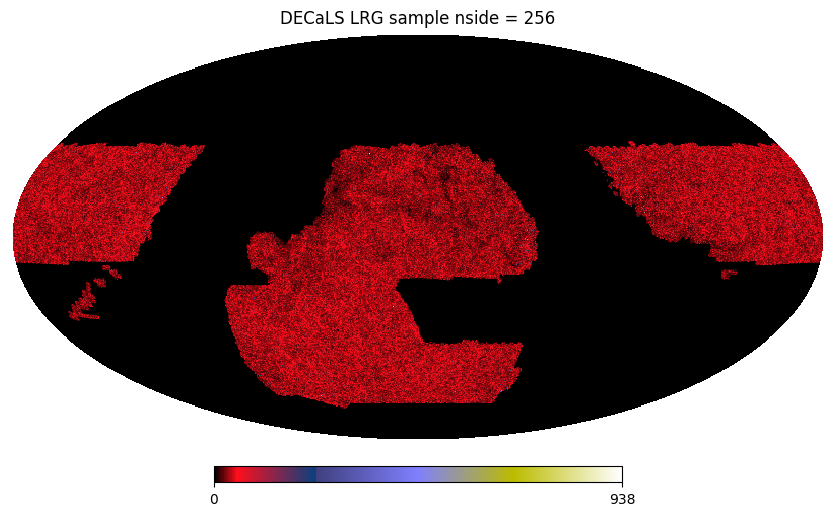

In [197]:
hp.mollview(decalsmap,cmap="gist_stern",title="DECaLS LRG sample nside = 256")
savefig("decals.png")